In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
# import sys

# sys.path.extend(
#     [
#         'src/poultry',
#     ]
# )

In [4]:
import rocchio as r

In [5]:
import json

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
qrels_nist = r.read_qrels('eval/RTS17/eval_qrelsfile', 'NIST')

In [7]:
qrels_mobile = qrels_nist.copy()
qrels_mobile.name = 'Mobile'
qrels_mobile.update(r.read_qrels('eval/RTS17/gundog/feedback/mobile-majority.txt', 'Mobile'))

In [8]:
point_nist = r.read_point(
    'ngram-length(3)_keep-spam(1)_language(en)_extract-retweets(0)_keep-retweets(1)_negative-distance-threshold(0.8)_sample(1)_feedback(nist).point'
)

In [9]:
point_mobile = r.read_point(
    'ngram-length(3)_keep-spam(1)_language(en)_extract-retweets(0)_keep-retweets(1)_negative-distance-threshold(0.8)_sample(1)_feedback(mobile-majority).point'
)

In [10]:
point_feedback_exact = r.read_point(
    'ngram-length(3)_feedback-pattern(mobile-majority)_feedback(nist)_pattern-mode(exact).point'
)

In [11]:
point_feedback_amount = r.read_point(
    'ngram-length(3)_feedback-pattern(mobile-majority)_feedback(nist)_pattern-mode(amount).point'
)

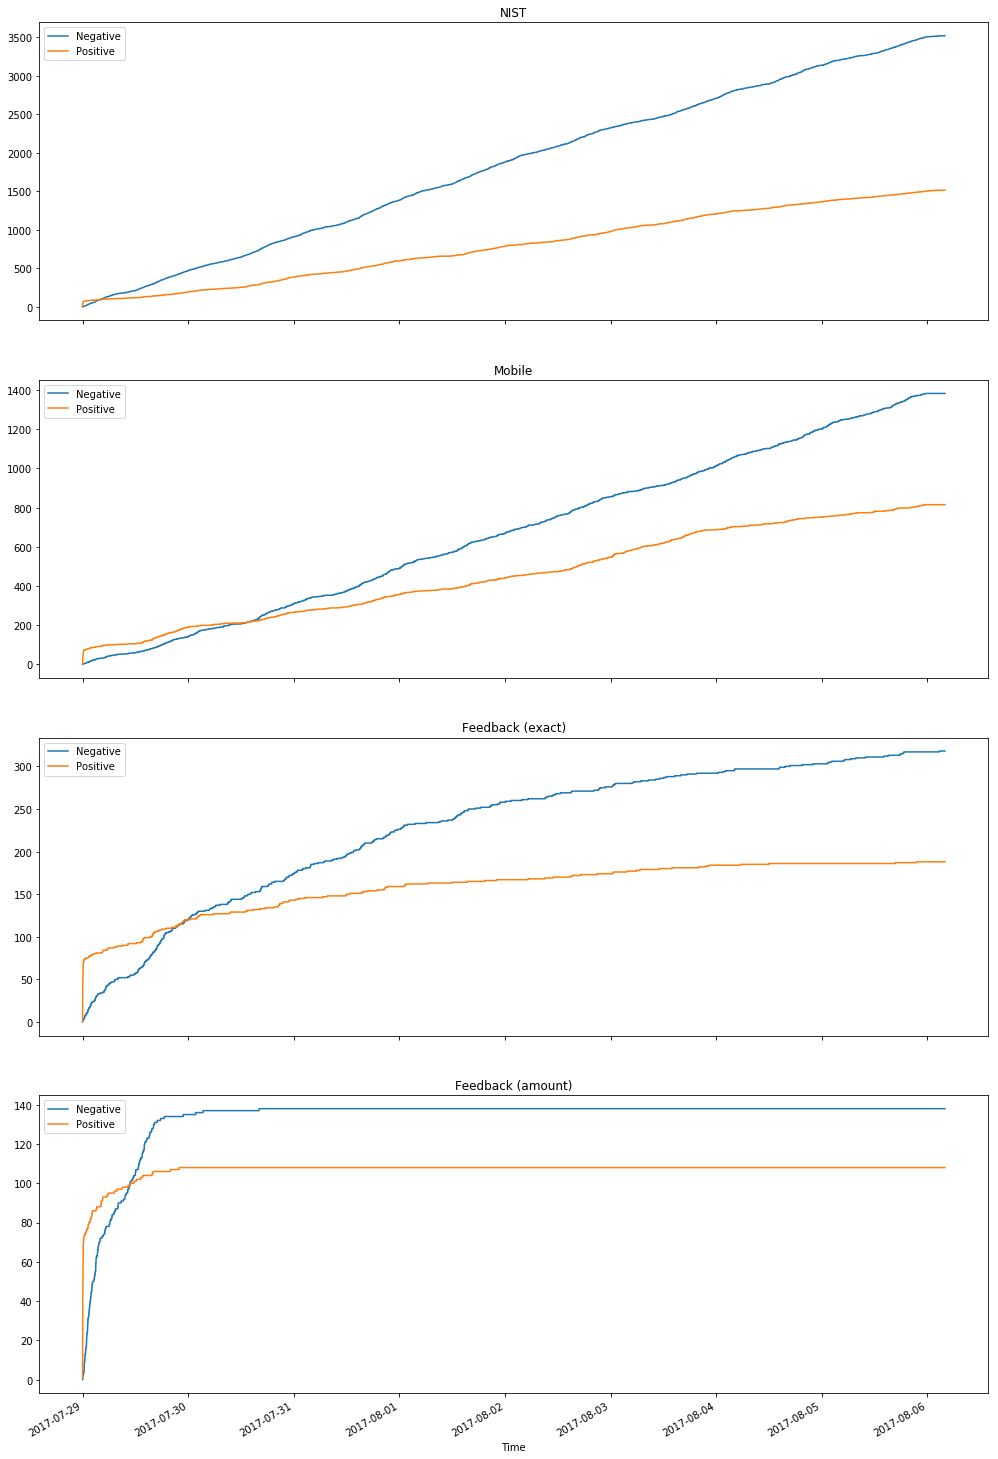

In [36]:
_to_plot = [
    (point_nist, 'NIST'),
    (point_mobile, 'Mobile'),
    (point_feedback_exact, 'Feedback (exact)'),
    (point_feedback_amount, 'Feedback (amount)'),
]

fig, axs = plt.subplots(len(_to_plot), sharex=True, figsize=(17, 7 * len(_to_plot)))

for ax, (point, title) in zip(axs, _to_plot):
    r.plot_feedback(point, ax=ax, title=title)

In [30]:
evaluation_nist = r.evaluate(point_nist, qrels_nist)

In [31]:
evaluation_mobile = r.evaluate(point_mobile, qrels_mobile)

In [32]:
evaluation_feedback_exact = r.evaluate(point_feedback_exact, qrels_mobile)

In [33]:
evaluation_feedback_amount = r.evaluate(point_feedback_amount, qrels_mobile)

In [34]:
_to_plot = [
    (evaluation_nist, 'NIST'),
    (evaluation_mobile, 'Mobile'),
    (evaluation_feedback_exact, 'Feedback (exact)'),
    (evaluation_feedback_amount, 'Feedback (amount)'),
]

# fig, axs = plt.subplots(len(_to_plot), sharex=True, figsize=(17, 6 * len(_to_plot)))

evaluation_over_time = None
for evaluation, title in _to_plot:
    e = r.evaluation_over_time(evaluation, ax=ax, title=title)
    
    e.columns = pd.MultiIndex.from_product([e.columns, [title]])

    if evaluation_over_time is None:
        evaluation_over_time = e
    else:
        evaluation_over_time = evaluation_over_time.merge(e, left_index=True, right_index=True, how='outer')

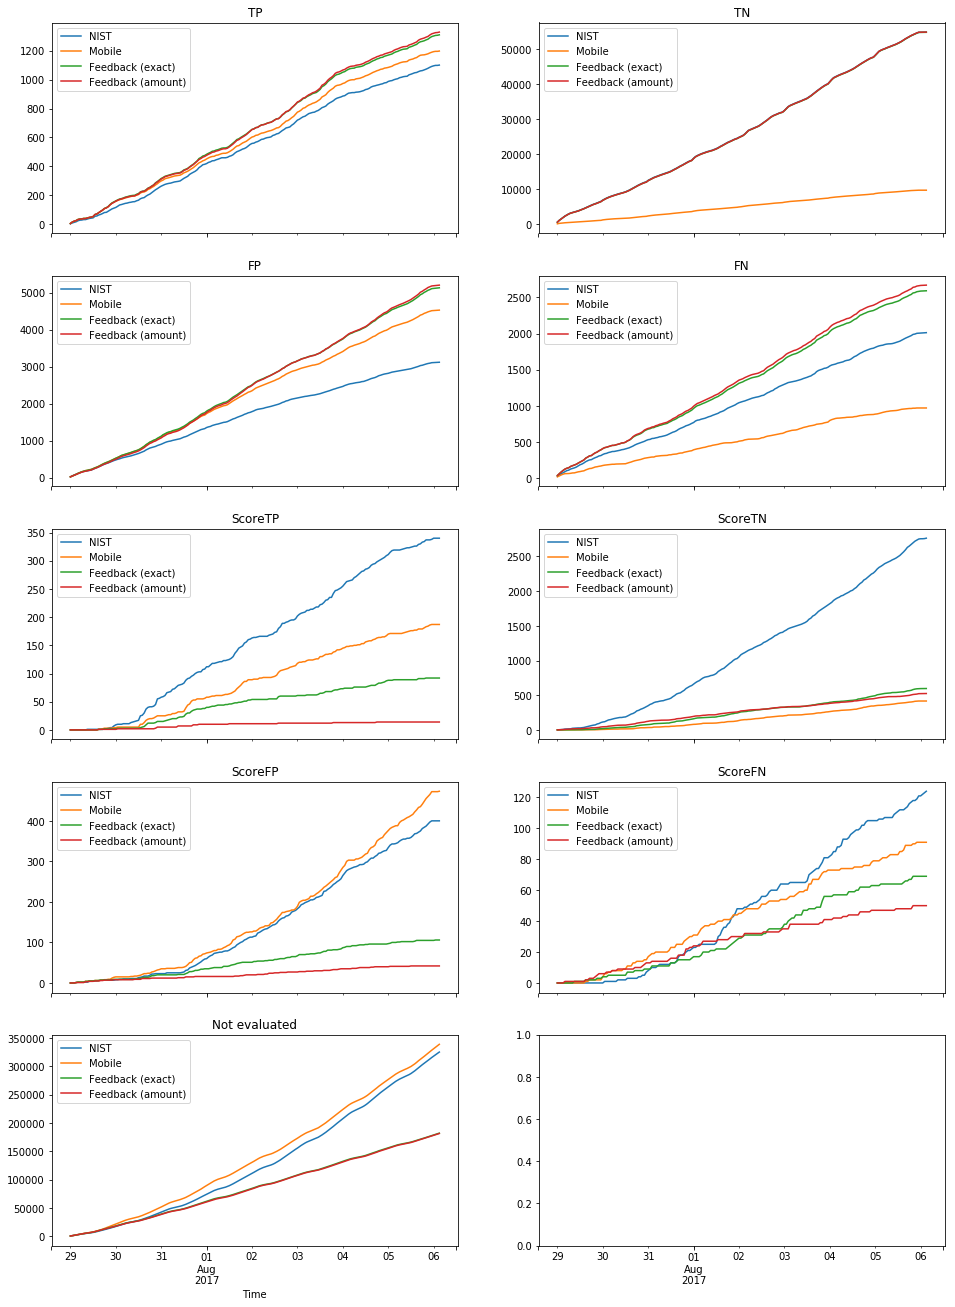

In [37]:
_to_plot = [
    ['TP', 'TN'],
    ['FP', 'FN'],
    ['ScoreTP', 'ScoreTN'],
    ['ScoreFP', 'ScoreFN'],
    ['Not evaluated'],
]

fig, axs = plt.subplots(len(_to_plot), 2, sharex=True, figsize=(16, 4.5 * len(_to_plot)))

for what_, axs_ in zip(_to_plot, axs):
    for what, ax in zip(what_, axs_):
        if what:
            evaluation_over_time[what].plot(ax=ax, title=what)

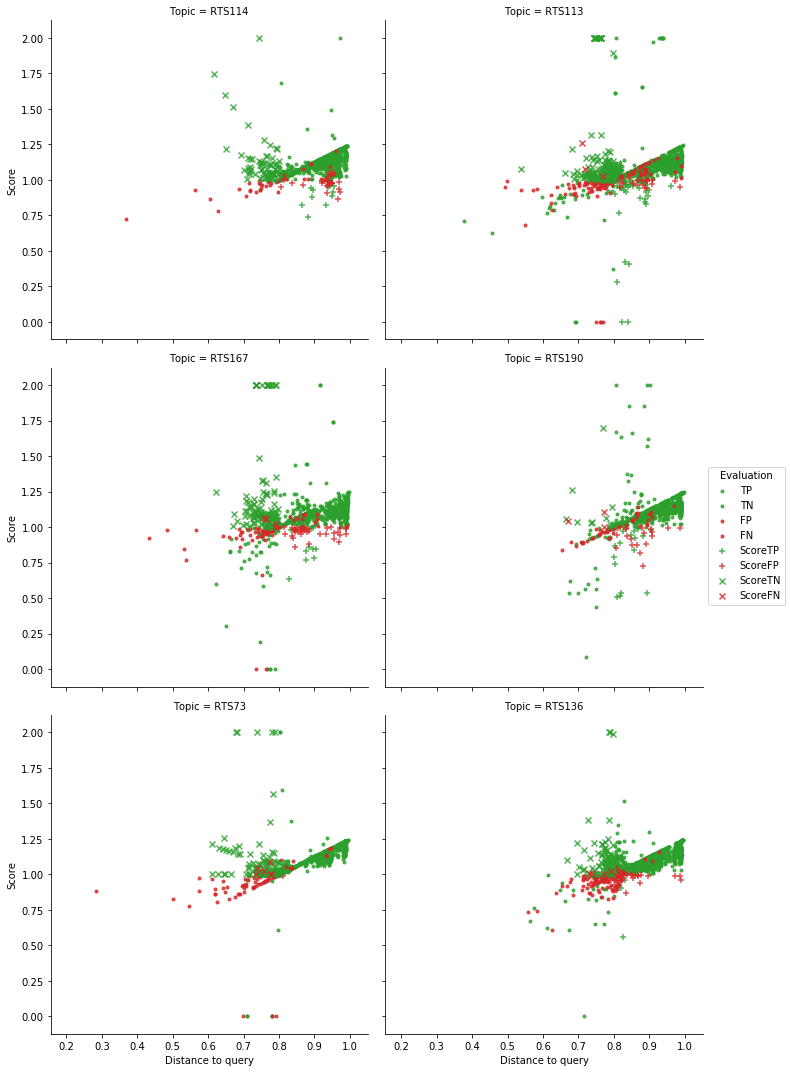

In [42]:
r.plot_evaluation(evaluation_nist);

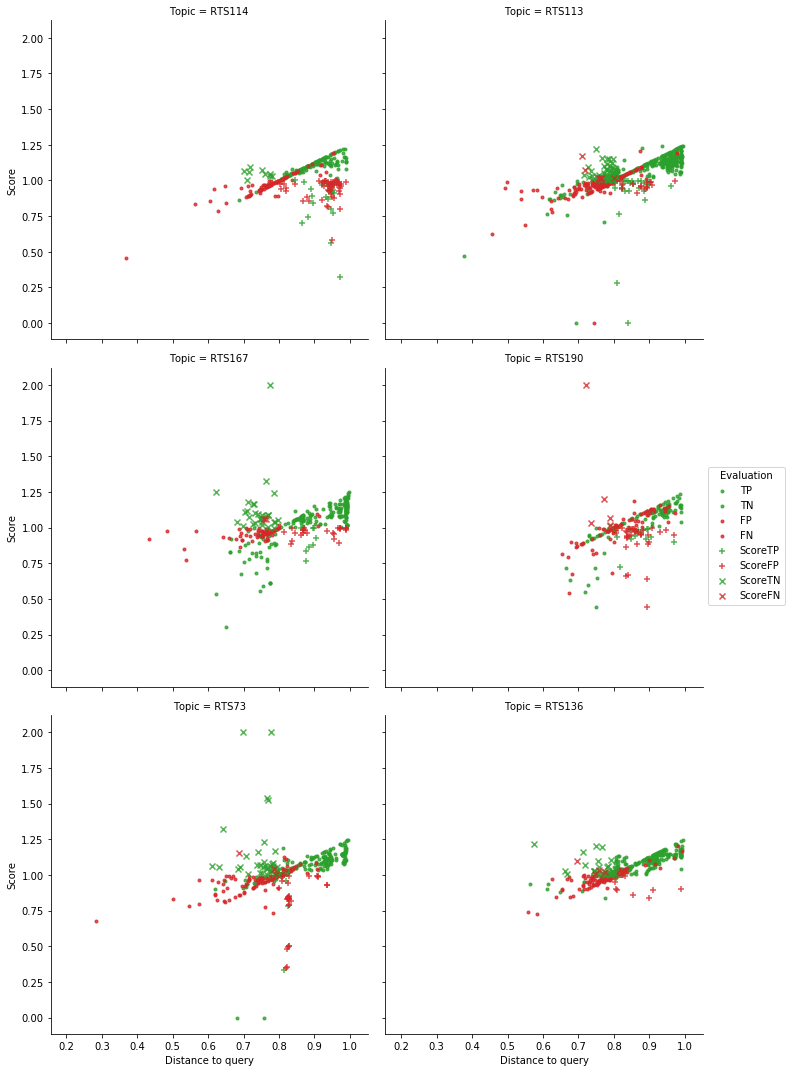

In [43]:
r.plot_evaluation(evaluation_mobile);

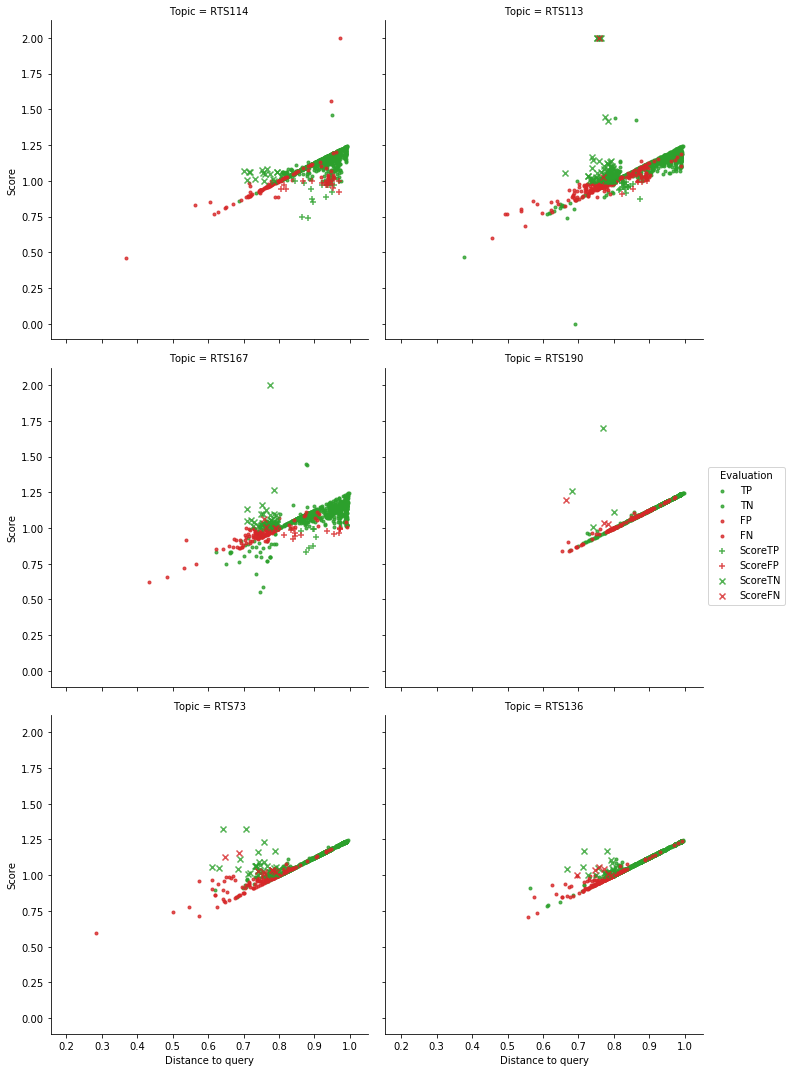

In [44]:
r.plot_evaluation(evaluation_feedback_exact);

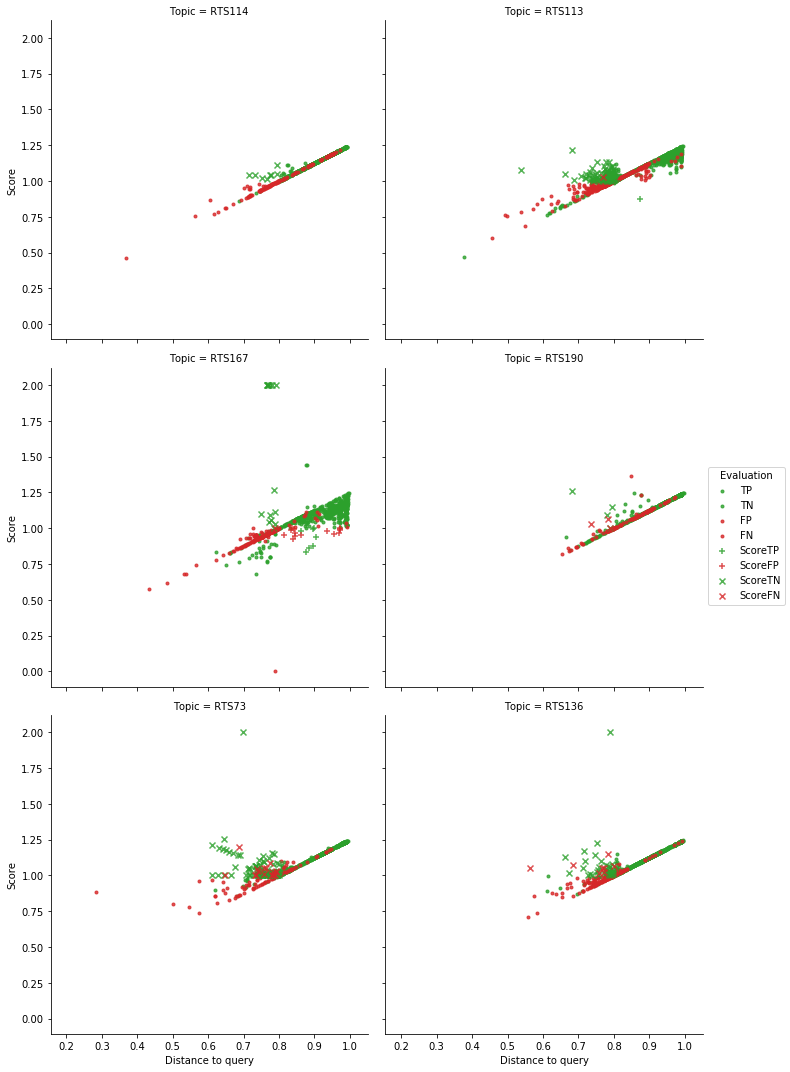

In [45]:
r.plot_evaluation(evaluation_feedback_amount);

In [ ]:
effect = by_topic.groupby(['Topic', 'Kind']).size().unstack('Kind').fillna(0)

In [ ]:
total_effect = effect['ScoreTP'] + effect['ScoreTN'] + effect['ScoreFP'] + effect['ScoreFN']

total_effect.plot.hist();

In [ ]:
pd.concat(
    [
        total_effect.sort_values(ascending=False).head(10),
#         total_effect.sort_values(ascending=False).tail(),
    ]
)

In [ ]:
for what, judgment in [
    ('Error', 'Relevance'),
    ('Error (NIST)', 'NIST'),
    ('Error (Mobile)', 'Mobile'),
]:
    by_topic[what] = by_topic.apply(
        lambda r: {
            (True, True, True): 'TP',
            (True, True, False): 'FP',
            (False, False, True): 'FN',
            (False, False, False): 'TP',        

            (True, False, True): 'TN',
            (True, False, False): 'FN',
            (False, True, True): 'TP',
            (False, True, False): 'FP',
        }.get(tuple(r.loc[['retrieve_query', 'retrieve', judgment]].values)),
        axis='columns',
    )

In [ ]:
for what in 'Error', 'Error (NIST)', 'Error (Mobile)':
    _ = by_topic.groupby(['Topic', what]).size().unstack(what).fillna(0)

    _bs = 1 ** 2
    FP = point['retrieve'].sum(axis='rows') -_.TP
    _['F'] = ((1 + _bs) * _.TP) / ((1 + _bs) * _.TP + _bs * _.FN + FP)

#     _['F'].plot.hist()

    print('F (avg per topic, {}): {:0.2f}'.format(what, _.F.mean()))

In [ ]:
for what in 'Error', 'Error (NIST)', 'Error (Mobile)':
    _ = by_topic.groupby(what).size()

    _bs = 1 ** 2
    FP = (point['retrieve'] == True).sum().sum() -_.TP
    print(
        'F (over all topics, {}): {:0.2f}'.format(
            what,
            ((1 + _bs) * _.TP) / ((1 + _bs) * _.TP + _bs * _.FN + FP)
        )
    )

In [ ]:
_ = pd.DataFrame(list(qrels_nist.align(qrels_mobile))).T

with open('eval/RTS17/gundog/topic-filter.txt') as f:
    topic_filter = set(l.strip() for l in f)

_ = _[_['NIST'].isna()].reset_index('topic').groupby('topic').size()[topic_filter].sort_values(ascending=False)

_.plot.hist();

_.head(20)

In [ ]:
# (
#     by_topic.loc[
#         (by_topic['Distance to query'] <= 0.8) & (by_topic['retrieve'] == False),
#         ['Topic', 'Relevance']
#     ]
# ).groupby(['Topic', 'Relevance']).size().unstack('Relevance').sort_values(
#     False, # Most improved recall
# #     True, # Most deteriorated recall
#     ascending=False
# ).head()

In [ ]:
# (
#     by_topic.loc[
#         (by_topic['Distance to query'] > 0.8) & (by_topic['retrieve'] == True),
#         ['Topic', 'Relevance']
#     ]
# ).groupby(['Topic', 'Relevance']).size().unstack('Relevance').sort_values(
# #     True, # Most improved precision
#     False, # Most deteriorated precision
#     ascending=False
# ).head()

In [ ]:
# _ = by_topic.groupby('Topic').apply(lambda df: df['Relevance'].value_counts()).unstack(1)
# _['Total'] = _.sum(axis='columns')
# _['True to False']  = _[True] / _[False]
# _.sort_values('True to False', inplace=True, ascending=False)
# _.head(10)

In [ ]:
# sns.swarmplot(
#     data=distance_score.loc['RTS212'], x='Variable', y='Value',
#     hue='Relevance', hue_order=['Non-relevant', 'Relevant'],
#     dodge=True,
# );

In [ ]:
# sns.swarmplot(
#     data=distance_score.loc['RTS48'], x='Variable', y='Value',
#     hue='Relevance', hue_order=['Non-relevant', 'Relevant'],
#     dodge=True,
# );

In [ ]:
# sns.swarmplot(
#     data=distance_score.loc['RTS207'], x='Variable', y='Value',
#     hue='Relevance', hue_order=['Non-relevant', 'Relevant'],
#     dodge=True,
# );

In [ ]:
# sns.swarmplot(
#     data=distance_score.loc['RTS94'], x='Variable', y='Value',
#     hue='Relevance', hue_order=['Non-relevant', 'Relevant'],
#     dodge=True,
# );

In [ ]:
# sns.swarmplot(
#     data=distance_score.loc['RTS47'], x='Variable', y='Value',
#     hue='Relevance', hue_order=['Non-relevant', 'Relevant'],
#     dodge=True,
# );

In [ ]:
# (
#     point
# #     .sort_values(
# #         [
# #     #             ('Relevance', 'RTS212'),
# #                 ('Distance to query', 'RTS212'),
# #     #             ('Distance to query', 'RTS48'),
# #     #             ('Score', 'RTS212'),
# #     #             ('Score', 'RTS48'),
# #     #             ('Relevance', 'RTS212'),
# #     #             ('Relevance', 'RTS48'),
# #         ],
# #         ascending=True,
# #     )
#     [
#         [
#             ('Distance to query', 'RTS212'),
#             ('Score', 'RTS212'),
#             ('retrieve', 'RTS212'),
#             ('Relevance', 'RTS212'),
#             ('Distance to positive', 'RTS212'),
#             ('Distance to negative', 'RTS212'),
#             ('Positive', 'RTS212'),
#             ('Negative', 'RTS212'),
#         ]
#     ]
#     .dropna(subset=[('Relevance', 'RTS212')], axis='rows', how='any')
# )

In [ ]:
# distance_score = (
#     point[['Distance to query', 'Score', 'Relevance', 'retrieve']]
#     .stack(['Topic'])
#     .set_index(['retrieve'] , append=True)
#     .dropna(subset=['Relevance'])
#     .set_index('Relevance', append=True)
#     .stack().to_frame('Value')
#     .reset_index()
#     .set_index(['Topic', 'tweet_id'])
# )
# distance_score = distance_score[distance_score['Relevance'] >= 0]
# distance_score['Relevance'] = distance_score['Relevance'] > 0

# # distance_score.loc[:, 'Value'] = 1 / (1 + np.exp(-distance_score['Value']))

# distance_score.loc[distance_score['Relevance'] > 0, 'Relevance'] = 'Relevant'
# distance_score.loc[distance_score['Relevance'] == 0, 'Relevance'] = 'Non-relevant'

# distance_score['Error'] = distance_score.apply(
#     lambda r: {
#         ('Relevant', True): 'TP',
#         ('Relevant', False): 'FN',
#         ('Non-relevant', True): 'FP',
#         ('Non-relevant', False): 'TN',
#     }[r['Relevance'], r['retrieve'] if r['Variable'] == 'Score' else r['Value'] < 0.8],
#     axis='columns',
# )

In [ ]:
# sns.swarmplot(
#     distance_score.reset_index().set_index('Variable')
#     .loc['Score', ['Topic', 'Relevance']]
#     .reset_index()
#     .groupby(['Topic', 'Relevance'])
#     .size(),
# #     .unstack('Topic')
#     dodge=True,
# );

In [ ]:
# !mkdir -p eval/RTS17/plots/

In [ ]:
# f, ax = plt.subplots(figsize=(14, 7))

# sns.violinplot(
#     data=distance_score, x='Variable', y='Value',
#     hue='Relevance', hue_order=['Non-relevant', 'Relevant'], dodge=True,
#     ax=ax,
# );

# f.savefig('eval/RTS17/plots/distance-score-comparison.pdf')

In [ ]:
# f, ax = plt.subplots(figsize=(14, 7))

# sns.swarmplot(
#     data=distance_score, x='Variable', y='Value', hue='Error',
#     hue_order=[
#         'FN', 'FP', 'TN', 'TP',
#     ],
#     palette={
#         'FN': 'r',
#         'TN': 'g',
#         'FP': 'r',
#         'TP': 'g',
#         'N': 'r',
#         'P': 'g',
#     },
#     dodge=True,
#     ax=ax,
# );

# f.savefig('eval/RTS17/plots/distance-score-comparison-error-type.pdf')

# Mobile asessor agreement over time

In [ ]:
mobile = pd.read_csv(
    'eval/RTS17/qrels-crowd',
    sep='\s+',
    header=None,
    names=['Topic', 'Assessor', 'tweet_id', 'Judgment', 'timestampe'],
    index_col=['Topic', 'tweet_id'],
)

In [ ]:
mobile_judgment = (
    mobile['Judgment']
    .groupby(level=['Topic', 'tweet_id'])
    .value_counts()
    .unstack('Judgment')
    [[0, 1, 2]]
    .fillna(0)
)

In [ ]:
mobile_judgment['Disagreement'] = mobile_judgment.max(axis='columns') != mobile_judgment.sum(axis='columns')

In [ ]:
disagreement = (
    mobile_judgment
    .sort_index()
    [['Disagreement']]
#     .unstack('Topic')
#     .fillna(0)
#     .cumsum(axis='rows')
#     .sum(axis='columns')
#     .plot(use_index=False)
);

In [ ]:
disagreement['position'] = disagreement.groupby(level=['Topic']).cumcount()
disagreement['disagreements'] = disagreement['Disagreement'].groupby(level=['Topic']).cumsum()

In [ ]:
(
    disagreement.loc[
        (disagreement['Disagreement'] & disagreement['disagreements'] == 1),
        'position'
    ]
    .groupby(level=['Topic']).first()
    .value_counts()
#     .sort_values(ascending=False)
    .sort_index()
#     .head(20)
    .plot(kind='bar', figsize=(14,7))
);

In [ ]:
# mobile_judgment.loc['RTS151']